In [47]:
import sys
import os

print('Python %s on %s' % (sys.version, sys.platform))

package_path = os.path.abspath(os.path.join(os.path.expanduser(os.getcwd()), os.pardir))
print(package_path)

"""
Adding the path to the neuralmagic-pytorch extension to the path so it isn't necessary to have it installed
"""
sys.path.extend([package_path])


Python 3.6.8 (v3.6.8:3c6b436a57, Dec 24 2018, 02:04:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)] on darwin
/Users/markkurtz/code/neuralmagic/Shared/neuralmagicml-pytorch


In [48]:
from neuralmagicML.models import resnet50
import ipywidgets as widgets


"""
change the desired model to run here
"""
model = resnet50()
print('Created model {}'.format(model.__class__.__name__))
model = model.eval()

print('\nChoose the device to run on')
device_choice = widgets.ToggleButtons(options=['cpu', 'cuda'], description='Device')
display(device_choice)

Created model ResNet

Choose the device to run on


ToggleButtons(description='Device', options=('cpu', 'cuda'), value='cpu')

In [49]:
from neuralmagicML.notebooks import ASAnalyzerWidgets

device = device_choice.value

print('running on device {}'.format(device))
print('creating activation sparsity analyzer widgets (need to execute the model, so may take some time)...')
wid, analyzer_layers = ASAnalyzerWidgets.interactive_module(model, device, inp_dim=(1, 3, 224, 224))
display(wid)


running on device cpu
creating activation sparsity analyzer widgets (need to execute the model, so may take some time)...


Accordion(children=(Box(children=(VBox(children=(VBox(children=(Checkbox(value=False, description='toggle all …

In [50]:
from neuralmagicML.sparsity import ASAnalyzerModule

analyzer_module = ASAnalyzerModule(model, analyzer_layers)
print('created analyzer module for {} with {} analyzed layers'
      .format(model.__class__.__name__, len([lay for lay in analyzer_layers if lay.enabled])))


created analyzer module for ResNet with 54 analyzed layers


In [51]:
from neuralmagicML.datasets import ImageNetDataset, EarlyStopDataSet

"""
change the desired dataset to run on and the path to it here

Note, for the default ImageNetDataset you may run into issues with download if already downloaded (pytorch bug)
If this is case, set download=True and run. This will download the meta file but will not progress any further
After that set download=False and it will work
"""
dataset_root = os.path.abspath(os.path.expanduser('~/datasets/ILSVRC2012'))
dataset = ImageNetDataset(dataset_root, train=False, download=False)

print(dataset)

print('\nChoose the number of samples and batch size to run through the model for calculating AS')
print('(press enter if/after inputting manually)')
sample_size_slider = widgets.IntSlider(value=1, min=1, max=len(dataset), step=1, description='Samples:')
batch_size_slider = widgets.IntSlider(value=1, min=1, max=256, step=1, description='Batch Size:')
display(sample_size_slider)
display(batch_size_slider)


Dataset ImageNetDataset
    Number of datapoints: 50000
    Root location: /Users/markkurtz/datasets/ILSVRC2012
    Split: val

Choose the number of samples and batch size to run through the model for calculating AS
(press enter if/after inputting manually)


IntSlider(value=1, description='Samples:', max=50000, min=1)

IntSlider(value=1, description='Batch Size:', max=256, min=1)

In [52]:
import torch
from torch.utils.data import DataLoader
import progressbar


sample_size = sample_size_slider.value
batch_size = batch_size_slider.value

print('running model for {} samples from the dataset at batch size {}'
      .format(sample_size, batch_size))

data_loader = DataLoader(EarlyStopDataSet(dataset, sample_size), batch_size=batch_size, num_workers=4)
bar = progressbar.ProgressBar(
    widgets=['Running samples: ', progressbar.SimpleProgress(),
             ' [', progressbar.Percentage(), ']\t', 
             '\t(', progressbar.Timer(), '\t', progressbar.ETA(), ') '],
    maxval=sample_size)

with torch.no_grad():
    for batch, (*x_feature, y_lab) in enumerate(data_loader):
        y_lab = y_lab.to(device)
        x_feature = tuple([dat.to(device) for dat in x_feature])
        y_pred = model(*x_feature)
        bar.update(batch * batch_size if batch * batch_size < sample_size else sample_size - 1)
        
bar.finish()
print('Completed')
    

running model for 100 samples from the dataset at batch size 1


Running samples: 100 of 100 [100%]		(Elapsed Time: 0:00:23	Time:  0:00:23)     


Completed


Creating inputs sparsity chart...


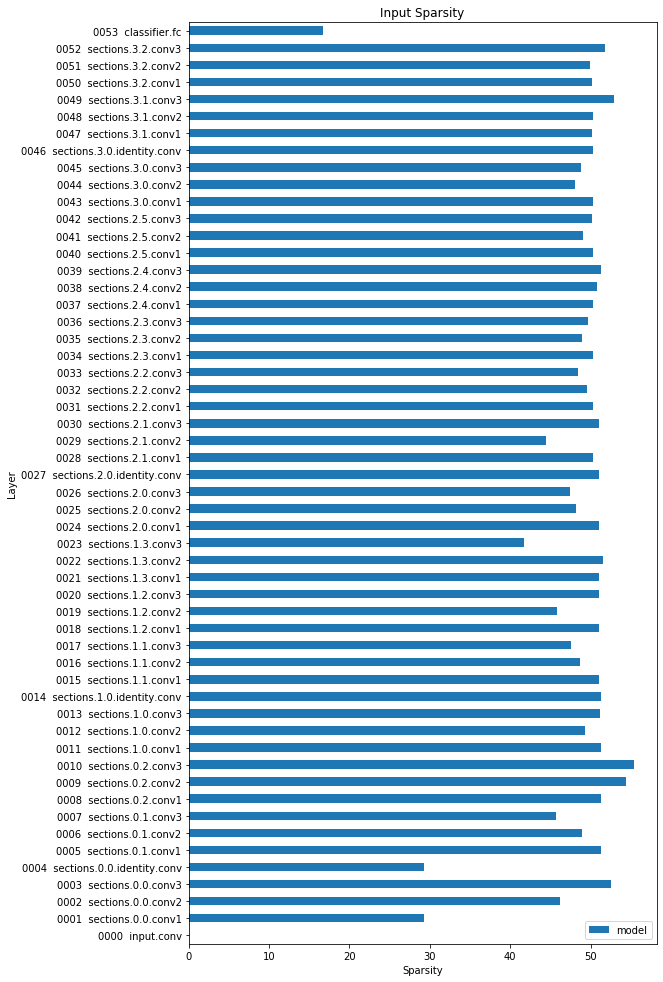

In [54]:
import matplotlib.pyplot as plt
import pandas


# plot input sparsities
input_sparsity_analyzers = [analyz for analyz in analyzer_layers if analyz.track_inputs_sparsity]

if len(input_sparsity_analyzers) > 0:
    print('Creating inputs sparsity chart...')
    data = {}
    
    for index, analyz in enumerate(input_sparsity_analyzers):
        data[analyz.name] = {'mean': analyz.inputs_sparsity_mean.item(),
                             'stddev': analyz.inputs_sparsity_std.item(),
                             'ordered_key': '{:04d}  {}'.format(index, analyz.name)}
    
    height = round(len(plt_data) / 4) + 3
    fig = plt.figure(figsize=(10, height))
    ax = fig.add_subplot(111)
    ax.set_title('Input Sparsity')
    ax.set_xlabel('Sparsity')
    ax.set_ylabel('Layer')
    plt.subplots_adjust(left=0.3, bottom=0.1, right=0.95, top=0.9)
    frame = pandas.DataFrame(data={'model': {val['ordered_key']: val['mean'] * 100.0
                                             for val in data.values()}})
    frame.plot.barh(ax=ax)
    plt.show()

# plot output sparsities
output_sparsity_analyzers = [analyz for analyz in analyzer_layers if analyz.track_outputs_sparsity]

if len(output_sparsity_analyzers) > 0:
    print('Creating outputs sparsity chart...')
    data = {}
    
    for index, analyz in enumerate(output_sparsity_analyzers):
        data[analyz.name] = {'mean': analyz.outputs_sparsity_mean.item(),
                             'stddev': analyz.outputs_sparsity_std.item(),
                             'ordered_key': '{:04d}  {}'.format(index, analyz.name)}
    
    height = round(len(plt_data) / 4) + 3
    fig = plt.figure(figsize=(10, height))
    ax = fig.add_subplot(111)
    ax.set_title('Output Sparsity')
    ax.set_xlabel('Sparsity')
    ax.set_ylabel('Layer')
    plt.subplots_adjust(left=0.3, bottom=0.1, right=0.95, top=0.9)
    frame = pandas.DataFrame(data={'model': {val['ordered_key']: val['mean'] * 100.0
                                             for val in data.values()}})
    frame.plot.barh(ax=ax)
    plt.show()

# plot input distributions
input_distribution_analyzers = [analyz for analyz in analyzer_layers if analyz.inputs_sample_size > 0]

if len(input_distribution_analyzers) > 0:
    print('Creating input distribution charts...')
    
    for analyz in input_distribution_analyzers:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        title = '{} Input Distribution'.format(analyz.name)
        ax.set_title(title)
        ax.set_xlabel('Value')
        ax.set_ylabel('Count')
        frame = pandas.DataFrame(data={title: torch.cat(analyz.inputs_sample).view(-1).tolist()})
        frame.hist(column=title, bins=256, ax=ax)
        plt.show()

# plot output distributions
output_distribution_analyzers = [analyz for analyz in analyzer_layers if analyz.outputs_sample_size > 0]

if len(output_distribution_analyzers) > 0:
    print('Creating output distribution charts...')
    
    for analyz in output_distribution_analyzers:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        title = '{} Output Distribution'.format(analyz.name)
        ax.set_title(title)
        ax.set_xlabel('Value')
        ax.set_ylabel('Count')
        frame = pandas.DataFrame(data={title: torch.cat(analyz.outputs_sample).view(-1).tolist()})
        frame.hist(column=title, bins=256, ax=ax)
        plt.show()
